In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from tqdm import tqdm




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\fishd\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\fishd\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\fishd\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "C

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [40]:
# 設定隨機種子
seed_value = 421
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

# 確保在使用 CUDA 時的確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [41]:
# 讀取資料
data = pd.read_excel('C:/Users/fishd/Desktop/Github/FTIR_dust/dataset/逢甲LOC&ROC.xlsx')



In [42]:
data.head()

,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,757,756,755,754,753,752,751,750,ROC%,LOC%
0,QGL_01_B1,97.885832,97.884535,97.883170,97.881979,97.881189,97.880958,97.880969,97.880530,97.879175,...,95.216058,95.280923,95.356017,95.430625,95.495601,95.549600,95.600531,95.658170,0.205,2.228883
1,QGL_01_B3,97.756424,97.753833,97.751616,97.750424,97.750757,97.752500,97.754342,97.754717,97.753072,...,91.322891,91.443452,91.569730,91.695384,91.816096,91.932148,92.048570,92.170342,0.099,1.539269
2,QGL_02_B1,96.999404,96.996638,96.996201,96.998261,97.001636,97.004245,97.004401,97.001828,96.998055,...,96.371640,96.390851,96.405533,96.417533,96.428577,96.441736,96.461740,96.490230,0.091,2.066605
3,QGL_02_B3,97.012266,97.010216,97.009921,97.011835,97.014948,97.017178,97.017011,97.014713,97.012262,...,93.606906,93.669565,93.722866,93.765526,93.803944,93.847722,93.903514,93.971849,0.215,1.140601
4,QGL_03_B1,97.110237,97.108371,97.108268,97.109737,97.112161,97.114404,97.115182,97.114021,97.111765,...,93.560204,93.636977,93.700211,93.749640,93.794979,93.843773,93.897051,93.956556,0.100,2.157583


In [43]:
# 設定 TOC % 欄位名稱
toc_column = 'ROC%'

# 計算 IQR（四分位距）
Q1 = data[toc_column].quantile(0.25)
Q3 = data[toc_column].quantile(0.75)
IQR = Q3 - Q1

# 定義離群值範圍
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 過濾掉離群值
data_filtered = data[(data[toc_column] >= lower_bound) & (data[toc_column] <= upper_bound)]

# 顯示過濾後的資料
data_filtered.head()


,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,757,756,755,754,753,752,751,750,ROC%,LOC%
0,QGL_01_B1,97.885832,97.884535,97.883170,97.881979,97.881189,97.880958,97.880969,97.880530,97.879175,...,95.216058,95.280923,95.356017,95.430625,95.495601,95.549600,95.600531,95.658170,0.205,2.228883
1,QGL_01_B3,97.756424,97.753833,97.751616,97.750424,97.750757,97.752500,97.754342,97.754717,97.753072,...,91.322891,91.443452,91.569730,91.695384,91.816096,91.932148,92.048570,92.170342,0.099,1.539269
2,QGL_02_B1,96.999404,96.996638,96.996201,96.998261,97.001636,97.004245,97.004401,97.001828,96.998055,...,96.371640,96.390851,96.405533,96.417533,96.428577,96.441736,96.461740,96.490230,0.091,2.066605
3,QGL_02_B3,97.012266,97.010216,97.009921,97.011835,97.014948,97.017178,97.017011,97.014713,97.012262,...,93.606906,93.669565,93.722866,93.765526,93.803944,93.847722,93.903514,93.971849,0.215,1.140601
4,QGL_03_B1,97.110237,97.108371,97.108268,97.109737,97.112161,97.114404,97.115182,97.114021,97.111765,...,93.560204,93.636977,93.700211,93.749640,93.794979,93.843773,93.897051,93.956556,0.100,2.157583


In [44]:
# 分離舊資料與新資料
old_data = data_filtered.iloc[:, 1:-2]
old_data.head()

,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,759,758,757,756,755,754,753,752,751,750
0,97.885832,97.884535,97.883170,97.881979,97.881189,97.880958,97.880969,97.880530,97.879175,97.877045,...,95.119671,95.165173,95.216058,95.280923,95.356017,95.430625,95.495601,95.549600,95.600531,95.658170
1,97.756424,97.753833,97.751616,97.750424,97.750757,97.752500,97.754342,97.754717,97.753072,97.750348,...,91.115205,91.213447,91.322891,91.443452,91.569730,91.695384,91.816096,91.932148,92.048570,92.170342
2,96.999404,96.996638,96.996201,96.998261,97.001636,97.004245,97.004401,97.001828,96.998055,96.995213,...,96.326422,96.348397,96.371640,96.390851,96.405533,96.417533,96.428577,96.441736,96.461740,96.490230
3,97.012266,97.010216,97.009921,97.011835,97.014948,97.017178,97.017011,97.014713,97.012262,97.011444,...,93.478877,93.541409,93.606906,93.669565,93.722866,93.765526,93.803944,93.847722,93.903514,93.971849
4,97.110237,97.108371,97.108268,97.109737,97.112161,97.114404,97.115182,97.114021,97.111765,97.109595,...,93.408036,93.480648,93.560204,93.636977,93.700211,93.749640,93.794979,93.843773,93.897051,93.956556


In [45]:
# 分離舊資料與新資料
new_data = data_filtered.iloc[-1, 1:-2]
old_data.columns = old_data.columns.astype(str)

# 對資料進行標準化
scaler = StandardScaler()
old_data_scaled = scaler.fit_transform(old_data)
new_data_scaled = scaler.transform(new_data.values.reshape(1, -1))

# 使用 PCA 進行降維
pca = PCA(n_components=100)
X_pca = pca.fit_transform(old_data_scaled)
new_pca = pca.transform(new_data_scaled)



c:\Users\fishd\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
# 目標變量
target = data_filtered.iloc[:, -1]
print(target.head())
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, random_state=seed_value)

# 將資料轉換為 PyTorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 調整輸入形狀以適應 CNN 模型
X_train_tensor = X_train_tensor.unsqueeze(1)  # 增加 channel 維度
X_test_tensor = X_test_tensor.unsqueeze(1)  # 增加 channel 維度

# 設定 DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



NameError: name 'data_filtered' is not defined

In [47]:
# 定義 CNN 模型
class CNNRegressor(nn.Module):
    def __init__(self, input_shape):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_shape = X_train_tensor.shape[1]
model = CNNRegressor(input_shape).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [48]:
from torchinfo import summary
summary(model, device=device)

Layer (type:depth-idx)                   Param #
CNNRegressor                             --
├─Conv1d: 1-1                            256
├─MaxPool1d: 1-2                         --
├─Conv1d: 1-3                            10,304
├─MaxPool1d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            131,200
├─Linear: 1-7                            8,256
├─Linear: 1-8                            2,080
├─Linear: 1-9                            33
Total params: 152,129
Trainable params: 152,129
Non-trainable params: 0

In [49]:
# 訓練模型
epochs = 1000
model.train()
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc=f"Train epochs {epochs}"):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.flatten(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 驗證損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    model.train()

# 評估模型
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor.to(device)).cpu().numpy().flatten()
    y_pred_test = model(X_test_tensor.to(device)).cpu().numpy().flatten()

train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f'train MSE: {train_mse}, train R²: {train_r2}')
print(f'test MSE: {test_mse}, test R²: {test_r2}')



Train epochs 1000: 100%|██████████| 1000/1000 [00:06<00:00, 164.20it/s]

train MSE: 0.0005600323643879947, train R²: 0.9156825948801535
test MSE: 0.009812717555605189, test R²: -0.8027719165496061


In [50]:
y_pred_train = model(X_train_tensor.to(device)).cpu().detach().numpy().flatten()
y_pred_test = model(X_test_tensor.to(device)).cpu().detach().numpy().flatten()

print("y_pred_train shape:", y_pred_train.shape)  # 應該是 (704,)


y_pred_train shape: (135,)


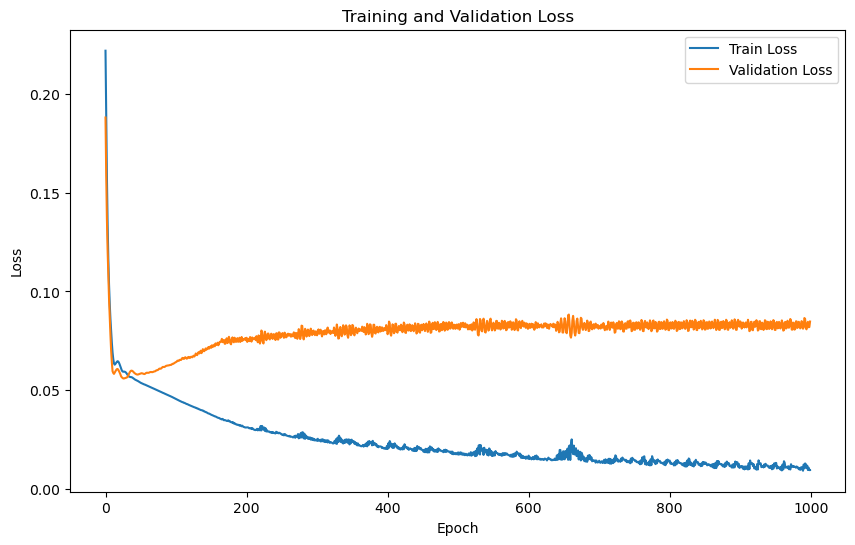

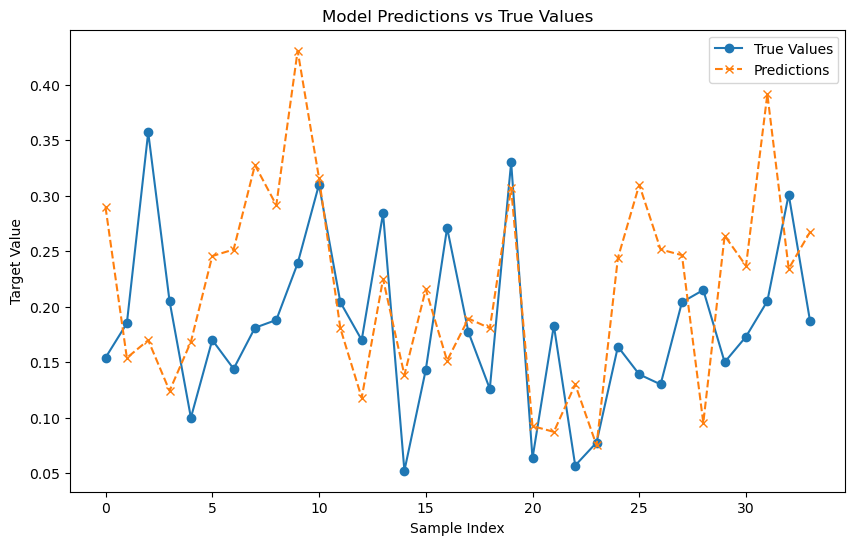

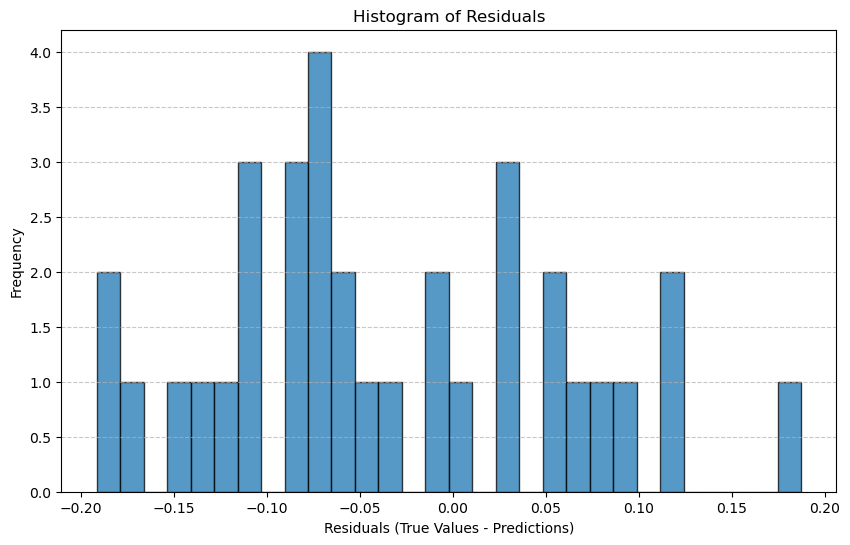

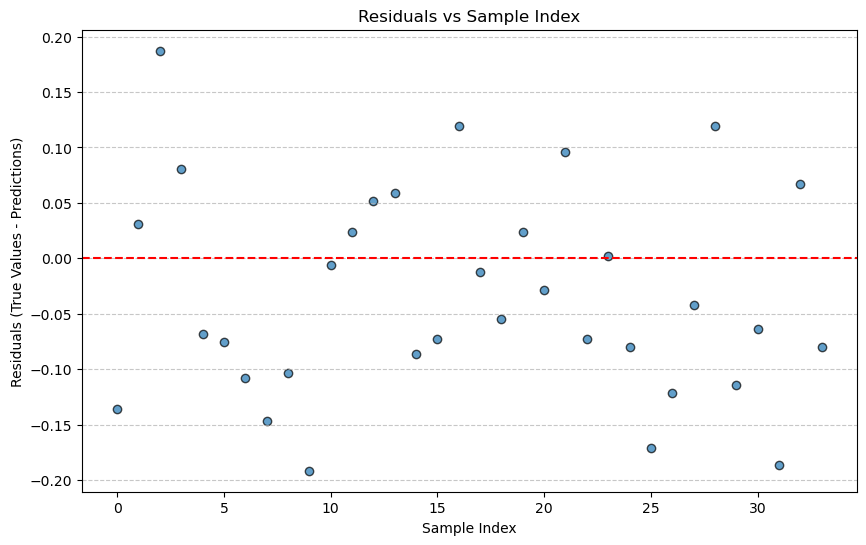

In [51]:
# 繪製訓練和驗證損失曲線
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# 繪製預測結果與真實值的比較
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', marker='o')
plt.plot(y_pred_test, label='Predictions', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Model Predictions vs True Values')
plt.show()


# 計算差值（實際值減去預測值）
residuals = y_test.values - y_pred_test

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.75, edgecolor='black')
plt.xlabel('Residuals (True Values - Predictions)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 計算誤差（Residuals）
residuals = y_test.values - y_pred_test

# 繪製散點圖
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)  # 繪製基準線 y=0
plt.xlabel('Sample Index')
plt.ylabel('Residuals (True Values - Predictions)')
plt.title('Residuals vs Sample Index')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [56]:
# 使用模型對新資料進行預測
model.eval()  # 設置模型為推論模式（evaluation mode）
X_new_tensor = torch.tensor(new_pca, dtype=torch.float32).unsqueeze(0).to(device)  # 增加 batch 維度
with torch.no_grad():  # 關閉梯度計算
    prediction = model(X_new_tensor).cpu().numpy().flatten()

print("Prediction for new data:", prediction[0])
print('True Value:', data.iloc[-1, -2])


Prediction for new data: 0.16315924
True Value: 0.159
